YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.4976 - loss: 0.6939 - val_accuracy: 0.4763 - val_loss: 0.7005
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5457 - loss: 0.6916 - val_accuracy: 0.4660 - val_loss: 0.7011
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5287 - loss: 0.6916 - val_accuracy: 0.4660 - val_loss: 0.6994
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5351 - loss: 0.6913 - val_accuracy: 0.4577 - val_loss: 0.7012
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5313 - loss: 0.6920 - val_accuracy: 0.4701 - val_loss: 0.7021
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5226 - loss: 0.6919 - val_accuracy: 0.4742 - val_loss: 0.7028
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5185 - loss: 0.6920 - val_accuracy: 0.4784 - val_loss: 0.7025
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5279 - loss: 0.6920 - val_accuracy: 0.4660 - val_loss: 0.

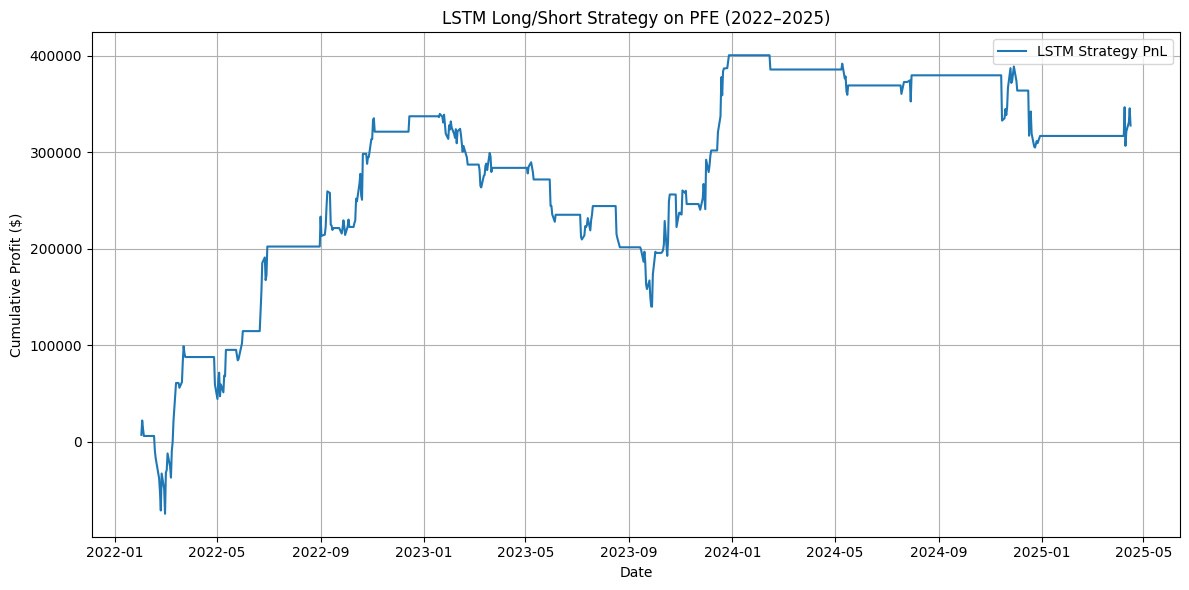

✅ Total PnL: $327,502.49
✅ Sharpe Ratio: 0.05


In [ ]:
# 📦 Install (if needed): pip install yfinance tensorflow
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 📅 Load data
df = yf.download("PFE", start="2010-01-01", end="2025-04-17").dropna()
df = df[['Close', 'Volume']]

# 🧠 Feature Engineering
def engineer_features(df):
    df = df.copy()
    df['Return_1d'] = df['Close'].pct_change()
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['MA_50'] = df['Close'].rolling(50).mean()
    df['MA_ratio'] = df['MA_10'] / df['MA_50'] - 1

    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26

    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    return df.dropna()

df = engineer_features(df)

# 🎯 Select features
features = ['Momentum_10', 'MA_ratio', 'RSI', 'MACD']
target = 'Target'

# 📊 Normalize
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 📦 Create LSTM sequences
def create_sequences(data, features, target, seq_len=20):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[features].iloc[i:i+seq_len].values)
        y.append(data[target].iloc[i+seq_len])
    return np.array(X), np.array(y)

# 🧪 Data Split
train_df = df[df.index < '2020-01-01']
val_df = df[(df.index >= '2020-01-01') & (df.index < '2022-01-01')]
test_df = df[df.index >= '2022-01-01']

X_train, y_train = create_sequences(train_df, features, target)
X_val, y_val = create_sequences(val_df, features, target)
X_test, y_test = create_sequences(test_df, features, target)

# 🧠 LSTM Model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

# ⏱️ Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

# 🔮 Predict on test
probs = model.predict(X_test).flatten()
test_df = test_df.iloc[-len(X_test):].copy()
test_df['Prob_Long'] = probs
test_df['Signal'] = 0
test_df.loc[test_df['Prob_Long'] > 0.55, 'Signal'] = 1
test_df.loc[test_df['Prob_Long'] < 0.45, 'Signal'] = -1

# 💰 Backtest
test_df['StrategyReturn'] = test_df['Return_1d'] * test_df['Signal']
test_df['PnL_$'] = 1_000_000 * test_df['StrategyReturn']
test_df['CumulativePnL'] = test_df['PnL_$'].cumsum()

# 📈 Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['CumulativePnL'], label='LSTM Strategy PnL')
plt.title("LSTM Long/Short Strategy on PFE (2022–2025)")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Results
total_pnl = test_df['PnL_$'].sum()
sharpe = test_df['StrategyReturn'].mean() / test_df['StrategyReturn'].std()
print(f"✅ Total PnL: ${total_pnl:,.2f}")
print(f"✅ Sharpe Ratio: {sharpe:.2f}")
